In [ ]:
# STEP 0 — Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

In [ ]:
# ==========================================================
# STEP 1 — Load Data
# ==========================================================
articles_path = r"E:\NEWSXPRESS\articles_rows.csv"   # News metadata
users_path    = r"E:\NEWSXPRESS\user_preferences.csv"               # User preference data

# Load both CSV files
articles = pd.read_csv(articles_path)
users = pd.read_csv(users_path)

# Display basic info
print("Articles shape:", articles.shape)
print("Users shape:", users.shape)

print("\n--- Articles ---")
display(articles.head())   # Use display() for better output in Jupyter

print("\n--- Users ---")
display(users.head())

Articles shape: (60, 14)
Users shape: (100, 4)

--- Articles ---


,id,title,summary,original_url,source_id,published_at,content_text,language_code,image_url,actors,place,topic,created_at,updated_at
0,0c9f6284-f156-44ac-83c2-f05a157ad6a9,India v South Africa: Women’s Cricket World Cu...,India is set to face South Africa in the Women...,https://www.theguardian.com/sport/live/2025/no...,98938dc5-7104-44ec-a4c3-764d056838a3,2025-11-02 09:51:00+00,NaN,en-IN,https://i.guim.co.uk/img/media/539189f911b5b81...,"[""India Women's Cricket Team"",""South Africa Wo...",Australia,Sports,2025-11-02 10:42:41.762+00,2025-11-02 10:42:41.762+00
1,1144af4f-9e0c-4673-9c45-ae02336d69ca,Mappls vs Google Maps: 5 Features that make In...,"Mappls, a homegrown navigation app in India, h...",https://www.indiatvnews.com/technology/news/ma...,65f7d197-b7d8-4051-a230-0536cf4816fc,2025-10-20 06:21:00+00,NaN,en-IN,https://resize.indiatvnews.com/en/resize/newbu...,"[""Mappls"",""Google Maps"",""India""]",India,Technology,2025-10-20 07:49:28.73+00,2025-10-20 07:49:28.731+00
2,123ae225-935c-4209-b9e6-c9c231e4873c,"US India visa news: Work permit, H-1B, Civic T...",The US has made three significant changes in t...,https://www.indiatoday.in/world/us-news/story/...,74a177bd-6ce7-4f2c-932c-9cd325478136,2025-11-01 10:39:00+00,NaN,en-IN,https://akm-img-a-in.tosshub.com/indiatoday/im...,"[""US Government"",""Trump Administration"",""India...",US,Politics,2025-11-02 10:01:12.946+00,2025-11-02 10:01:12.946+00
3,13ac12cc-ec63-429d-82ce-952e5cefdddd,'Even Trump doesn't know ... ': Army chief Upe...,Army chief Upendra Dwivedi expressed concerns ...,https://timesofindia.indiatimes.com/india/even...,27cd2bd0-2f7f-491e-8009-dc5e45857186,2025-11-01 17:36:00+00,NaN,en-IN,https://static.toiimg.com/thumb/msid-125019902...,"[""Upendra Dwivedi"",""Donald Trump"",""India""]",India,Politics,2025-11-02 10:01:10.68+00,2025-11-02 10:01:10.68+00
4,13bfc60b-3d8a-4e03-aa15-7ea74d0c1e81,GOAL OF THE MONTH – Goal 13 Climate Action - U...,The United Nations Sustainable Development Goa...,https://www.un.org/sustainabledevelopment/goal...,948ff75e-f7a1-4969-8e42-84d5cbc29f94,2025-10-29 17:16:00+00,NaN,en-IN,https://www.un.org/sustainabledevelopment/wp-c...,"[""United Nations""]",Global,Environment,2025-11-02 10:44:09.347+00,2025-11-02 10:44:09.348+00



--- Users ---


,UserID,PlaceLiked,ActorLiked,TopicLiked
0,U001,India,The police,Sports
1,U002,US,Kin of Andekar murder case accused,Crime
2,U003,Navi Mumbai,Women's World Cup 2025,Sports
3,U004,"Nithari village, India",World Health Organization (WHO),Business
4,U005,South Africa,Government of Pakistan,Sports


In [ ]:
# ==========================================================
# STEP 2 — Clean and Normalize Text Columns
# ==========================================================
def clean_token_list(x):
    """
    Safely convert stringified lists or comma-separated strings into clean token lists.
    """
    if pd.isna(x):
        return []
    if isinstance(x, str):
        try:
            val = literal_eval(x)
            if isinstance(val, list):
                return [v.strip().lower() for v in val if isinstance(v, str)]
        except:
            pass
        return [v.strip().lower() for v in x.split(",") if v.strip()]
    if isinstance(x, list):
        return [str(v).strip().lower() for v in x]
    return []

for col in ['ActorLiked', 'PlaceLiked', 'TopicLiked']:
    users[col] = users[col].apply(clean_token_list)

for col in ['actors', 'place', 'topic']:
    if col in articles.columns:
        articles[col] = articles[col].apply(clean_token_list)

In [ ]:
# ==========================================================
# STEP 3 — Create Combined Feature Lists
# ==========================================================
users['combined'] = users['ActorLiked'] + users['PlaceLiked'] + users['TopicLiked']
articles['combined'] = articles.get('actors', []) + articles.get('place', []) + articles.get('topic', [])


In [ ]:
# ==========================================================
# STEP 4 — Encode Tokens into Feature Vectors
# ==========================================================
mlb = MultiLabelBinarizer(sparse_output=False)
all_tokens = users['combined'].tolist() + articles['combined'].tolist()
mlb.fit(all_tokens)

user_features = pd.DataFrame(
    mlb.transform(users['combined']),
    index=users['UserID'],
    columns=mlb.classes_
)

article_features = pd.DataFrame(
    mlb.transform(articles['combined']),
    index=articles['id'],
    columns=mlb.classes_
)

print("\nFeature space size:", len(mlb.classes_))
print("User feature matrix:", user_features.shape)
print("Article feature matrix:", article_features.shape)



Feature space size: 174
User feature matrix: (100, 174)
Article feature matrix: (60, 174)


In [ ]:
# ==========================================================
# STEP 5 — Compute User–User Cosine Similarity
# ==========================================================
user_sim = pd.DataFrame(
    cosine_similarity(user_features),
    index=user_features.index,
    columns=user_features.index
)

print("\nUser–User Similarity Matrix:")
display(user_sim.head())


User–User Similarity Matrix:


UserID,U001,U002,U003,U004,U005,U006,U007,U008,U009,U010,...,U091,U092,U093,U094,U095,U096,U097,U098,U099,U100
UserID,,,,,,,,,,,,,,,,,,,,,
U001,1.000000,0.0,0.333333,0.288675,0.333333,0.288675,0.333333,0.000000,0.000000,0.0,...,0.333333,0.000000,0.333333,0.0,0.333333,0.000000,0.0,0.333333,0.333333,0.333333
U002,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.333333,0.333333,0.0,0.000000,0.333333,0.000000
U003,0.333333,0.0,1.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.288675,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
U004,0.288675,0.0,0.000000,1.000000,0.000000,0.500000,0.288675,0.000000,0.250000,0.0,...,0.288675,0.288675,0.288675,0.0,0.288675,0.000000,0.0,0.288675,0.288675,0.577350
U005,0.333333,0.0,0.333333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [ ]:
# ==========================================================
# STEP 6 — Define Recommendation Function
# ==========================================================
def recommend_articles_for_user(target_user, top_k=5, top_n=5):
    """
    Recommend articles for a given user using user–user collaborative filtering.
    """
    if target_user not in user_sim.index:
        raise ValueError("User not found.")
    
    # 1. Get top-K similar users (excluding self)
    similar_users = (
        user_sim.loc[target_user]
        .drop(target_user)
        .sort_values(ascending=False)
        .head(top_k)
    )
    
    # 2. Aggregate preferences weighted by similarity
    agg_profile = np.zeros(user_features.shape[1])
    for sim_user, sim_score in similar_users.items():
        agg_profile += sim_score * user_features.loc[sim_user].values
    if np.linalg.norm(agg_profile) > 0:
        agg_profile /= np.linalg.norm(agg_profile)
    
    # 3. Score each article using cosine similarity
    scores = article_features.dot(agg_profile)
    
    # 4. Rank and return top-N
    top_articles = (
        scores.sort_values(ascending=False)
        .head(top_n)
        .index
    )
    recs = articles.loc[articles['id'].isin(top_articles)].copy()
    recs['score'] = recs['id'].map(scores)
    return recs.sort_values('score', ascending=False)


In [ ]:
# ==========================================================
# STEP 7 — Test Recommendations
# ==========================================================
for user_id in users['UserID'][:5]:
    print(f"\n--- Recommendations for {user_id} ---")
    try:
        recs = recommend_articles_for_user(user_id, top_k=5, top_n=5)
        display(recs[['title', 'actors', 'place', 'topic', 'score']])
    except Exception as e:
        print(f"Error for {user_id}: {e}")



--- Recommendations for U001 ---


,title,actors,place,topic,score
16,LIVE: India vs South Africa – ICC Women’s Worl...,"[india, australia, icc women's world cup]",[australia],[sports],1.34840
18,"India vs South Africa, Women's World Cup Final...","[india, south africa, harmanpreet kaur, icc, n...","[north sound, antigua]",[sports],1.34840
25,Women’s World Cup 2025 final: India vs South A...,"[india, south africa, icc (international crick...",[india/south africa],[sports],1.34840
49,What happens if rain washes out Women's World ...,"[india, south africa, icc]",[england],[sports],1.34840
23,India's Women Health Campaign Sets 3 Guinness ...,"[government of india, indian government, lok s...",[india],[health],0.80904



--- Recommendations for U002 ---


,title,actors,place,topic,score
11,Inside the ‘House of Horrors’ mass murder case...,"[moninder singh pandher, supreme court of indi...","[nithari village, india]",[crime],1.088662
5,Kin of another Andekar murder case accused sho...,"[pune police, andekar murder case accused, kin...",[pune],[crime],0.952579
44,"10 Stabbed On London-Bound Train, 2 Suspects A...","[british transport police, metropolitan police...",[london],[crime],0.952579
10,Bishnoi Gang's Reign of Terror in Canada: Punj...,"[bishnoi gang, punjabi singer, canadian police]",[canada],[crime],0.816497
32,Mumbai: Crime Branch arrests man posing as Uni...,"[mumbai crime branch, union minister, personal...",[mumbai],[crime],0.816497



--- Recommendations for U003 ---


,title,actors,place,topic,score
49,What happens if rain washes out Women's World ...,"[india, south africa, icc]",[england],[sports],1.224745
8,IND W vs SA W World Cup Final Live Score: Rain...,"[india women, south africa women, harmanpreet ...",[navi mumbai],[sports],1.088662
16,LIVE: India vs South Africa – ICC Women’s Worl...,"[india, australia, icc women's world cup]",[australia],[sports],1.088662
18,"India vs South Africa, Women's World Cup Final...","[india, south africa, harmanpreet kaur, icc, n...","[north sound, antigua]",[sports],1.088662
25,Women’s World Cup 2025 final: India vs South A...,"[india, south africa, icc (international crick...",[india/south africa],[sports],1.088662



--- Recommendations for U004 ---


,title,actors,place,topic,score
13,India Technology News: Absolute Security Annou...,"[absolute security, absolute software, india]",[india],[business],1.34840
46,Taiwan seeks bigger tech presence in India as ...,"[taiwan, india, us, taiwan external trade deve...",[india],[business],1.34840
53,India’s media & entertainment sector to cross ...,"[trai chairman, india's media and entertainmen...",[india],[business],1.34840
56,Why Shah Rukh Khan is India’s biggest dream — ...,"[shah rukh khan, red chillies entertainment, k...",[india],[business],1.34840
23,India's Women Health Campaign Sets 3 Guinness ...,"[government of india, indian government, lok s...",[india],[health],0.94388



--- Recommendations for U005 ---


,title,actors,place,topic,score
49,What happens if rain washes out Women's World ...,"[india, south africa, icc]",[england],[sports],1.521278
18,"India vs South Africa, Women's World Cup Final...","[india, south africa, harmanpreet kaur, icc, n...","[north sound, antigua]",[sports],1.352247
25,Women’s World Cup 2025 final: India vs South A...,"[india, south africa, icc (international crick...",[india/south africa],[sports],1.352247
16,LIVE: India vs South Africa – ICC Women’s Worl...,"[india, australia, icc women's world cup]",[australia],[sports],1.183216
58,Rain threat looms! What happens if weather spo...,"[india women's cricket team, south africa wome...",[england],[sports],0.845154


In [ ]:
# ==========================================================
# STEP 8 — Save Results
# ==========================================================
user_features.to_csv("user_feature_matrix.csv")
article_features.to_csv("article_feature_matrix.csv")
user_sim.to_csv("user_similarity_matrix.csv")

print("\n✅ Done. Saved:")
print("user_feature_matrix.csv")
print("article_feature_matrix.csv")
print("user_similarity_matrix.csv")


✅ Done. Saved:
user_feature_matrix.csv
article_feature_matrix.csv
user_similarity_matrix.csv


In [ ]:
# ==========================================================
# STEP 9 — EVALUATE COLLABORATIVE FILTERING OUTPUT
# ==========================================================
uid = users['UserID'].iloc[0]   # change index to test different users
print(f"Top recommendations for user: {uid}")

recs = recommend_articles_for_user(uid, top_k=5, top_n=10)
display(recs[['id', 'title', 'actors', 'place', 'topic', 'score']])

Top recommendations for user: U001


,id,title,actors,place,topic,score
16,44429bf2-3c47-4f44-9b83-89b748350deb,LIVE: India vs South Africa – ICC Women’s Worl...,"[india, australia, icc women's world cup]",[australia],[sports],1.34840
18,502ac71e-9fe6-4968-928a-11b64b76c49f,"India vs South Africa, Women's World Cup Final...","[india, south africa, harmanpreet kaur, icc, n...","[north sound, antigua]",[sports],1.34840
25,66201114-9215-456e-8d07-dafad1ff8c22,Women’s World Cup 2025 final: India vs South A...,"[india, south africa, icc (international crick...",[india/south africa],[sports],1.34840
49,d879ee3f-333b-4f5c-8d4c-c3c28152b35b,What happens if rain washes out Women's World ...,"[india, south africa, icc]",[england],[sports],1.34840
13,40854a5a-15a1-4153-a1ea-4b6eaab657f7,India Technology News: Absolute Security Annou...,"[absolute security, absolute software, india]",[india],[business],0.80904
23,5f056985-d5cf-4fb4-8078-f7ef8e9b3378,India's Women Health Campaign Sets 3 Guinness ...,"[government of india, indian government, lok s...",[india],[health],0.80904
46,d5f2fbd6-62b0-4d8d-9ee5-5f3adfa0533e,Taiwan seeks bigger tech presence in India as ...,"[taiwan, india, us, taiwan external trade deve...",[india],[business],0.80904
51,dccca5f2-1691-4db2-8b98-95b8c4ef726c,Sonal Chaudhary – Environmental Researcher at ...,"[sonal chaudhary, the energy and resources ins...",[india],[environment],0.80904
0,0c9f6284-f156-44ac-83c2-f05a157ad6a9,India v South Africa: Women’s Cricket World Cu...,"[india women's cricket team, south africa wome...",[australia],[sports],0.67420
31,74babe49-6341-4f27-af7e-d659839e5fd7,"India vs South Africa LIVE Cricket Score, Wome...","[india women's cricket team, south africa wome...",[navi mumbai],[sports],0.67420


In [ ]:
# ==========================================================
# STEP 10 — OPTIONAL: WEIGHTING ACTOR / PLACE / TOPIC
# ==========================================================
# You can assign more importance to certain features.
# For example, if a user's topic preference matters most,
# give "TopicLiked" higher weight.
def weighted_combine(row, w_actor=1.5, w_place=1.0, w_topic=2.0):
    return (row['ActorLiked'] * int(w_actor) + 
            row['PlaceLiked'] * int(w_place) + 
            row['TopicLiked'] * int(w_topic))

users['combined'] = users.apply(weighted_combine, axis=1)

print("Weighted feature combination applied.")
display(users[['UserID', 'ActorLiked', 'PlaceLiked', 'TopicLiked', 'combined']].head())

Weighted feature combination applied.


,UserID,ActorLiked,PlaceLiked,TopicLiked,combined
0,U001,[the police],[india],[sports],"[the police, india, sports, sports]"
1,U002,[kin of andekar murder case accused],[us],[crime],"[kin of andekar murder case accused, us, crime..."
2,U003,[women's world cup 2025],[navi mumbai],[sports],"[women's world cup 2025, navi mumbai, sports, ..."
3,U004,[world health organization (who)],"[nithari village, india]",[business],"[world health organization (who), nithari vill..."
4,U005,[government of pakistan],[south africa],[sports],"[government of pakistan, south africa, sports,..."


In [ ]:
# ==========================================================
# STEP 11 — HYBRID RECOMMENDER SETUP (CONTENT + COLLABORATIVE)
# ==========================================================
# This section assumes your friend’s content-based model 
# also gives each article a score for each user.

# Example: Load content-based scores (if available)
# Format expected:
#   user_id, article_id, cb_score
# Example CSV: "content_based_scores.csv"

try:
    cb_scores = pd.read_csv("content_based_scores.csv")
    print("Content-based scores loaded.")
except FileNotFoundError:
    print("⚠️ No content_based_scores.csv found. Skipping hybrid fusion for now.")
    cb_scores = pd.DataFrame(columns=['user_id', 'article_id', 'cb_score'])

⚠️ No content_based_scores.csv found. Skipping hybrid fusion for now.


In [ ]:
# ==========================================================
# STEP 12 — COMBINE (HYBRID FUSION)
# ==========================================================
# Weighted combination of collaborative + content-based
def hybrid_recommendation(user_id, alpha=0.6):
    """
    alpha: weight for collaborative filtering (0.0–1.0)
           (1-alpha): weight for content-based filtering
    """
    # Collaborative recommendations
    rec_cf = recommend_articles_for_user(user_id, top_k=5, top_n=20)
    rec_cf = rec_cf[['id', 'score']].rename(columns={'id': 'article_id', 'score': 'cf_score'})
    
    # Content-based (if available)
    rec_cb = cb_scores[cb_scores['user_id'] == user_id][['article_id', 'cb_score']]
    
    # Merge both scores
    merged = rec_cf.merge(rec_cb, on='article_id', how='outer').fillna(0)
    merged['final_score'] = alpha * merged['cf_score'] + (1 - alpha) * merged['cb_score']
    
    # Attach article metadata
    merged = merged.merge(articles, left_on='article_id', right_on='id', how='left')
    return merged.sort_values('final_score', ascending=False).head(10)

# Example usage:
uid = users['UserID'].iloc[0]
print(f"Hybrid recommendations for user: {uid}")
display(hybrid_recommendation(uid, alpha=0.6)[['title', 'actors', 'place', 'topic', 'final_score']])

Hybrid recommendations for user: U001


C:\Users\Admin\AppData\Local\Temp\ipykernel_23880\3173712005.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = rec_cf.merge(rec_cb, on='article_id', how='outer').fillna(0)


,title,actors,place,topic,final_score
2,LIVE: India vs South Africa – ICC Women’s Worl...,"[india, australia, icc women's world cup]",[australia],[sports],0.809040
3,"India vs South Africa, Women's World Cup Final...","[india, south africa, harmanpreet kaur, icc, n...","[north sound, antigua]",[sports],0.809040
5,Women’s World Cup 2025 final: India vs South A...,"[india, south africa, icc (international crick...",[india/south africa],[sports],0.809040
18,What happens if rain washes out Women's World ...,"[india, south africa, icc]",[england],[sports],0.809040
19,Sonal Chaudhary – Environmental Researcher at ...,"[sonal chaudhary, the energy and resources ins...",[india],[environment],0.485424
4,India's Women Health Campaign Sets 3 Guinness ...,"[government of india, indian government, lok s...",[india],[health],0.485424
17,Taiwan seeks bigger tech presence in India as ...,"[taiwan, india, us, taiwan external trade deve...",[india],[business],0.485424
1,India Technology News: Absolute Security Annou...,"[absolute security, absolute software, india]",[india],[business],0.485424
13,Women's Cricket World Cup final - India vs Sou...,"[india women's cricket team, south africa wome...",[navi mumbai],[sports],0.404520
16,Dharmendra hospitalised after complaining of b...,[dharmendra],[india],[entertainment],0.404520


In [ ]:
# ==========================================================
# STEP 13 — OPTIONAL: EXPORT HYBRID RECOMMENDATIONS
# ==========================================================
# Save all final recommendations to CSV for analysis
all_recs = []
for uid in users['UserID']:
    hybrid = hybrid_recommendation(uid, alpha=0.6)
    hybrid['UserID'] = uid
    all_recs.append(hybrid)

final_recs = pd.concat(all_recs, ignore_index=True)
final_recs.to_csv("hybrid_recommendations.csv", index=False)

print("\n✅ Hybrid recommendations saved to hybrid_recommendations.csv")

C:\Users\Admin\AppData\Local\Temp\ipykernel_23880\3173712005.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = rec_cf.merge(rec_cb, on='article_id', how='outer').fillna(0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23880\3173712005.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = rec_cf.merge(rec_cb, on='article_id', how='outer').fillna(0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23880\3173712005.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version.


✅ Hybrid recommendations saved to hybrid_recommendations.csv


In [ ]:
# STEP 14 — NORMALIZE AND SCALE SCORES
from sklearn.preprocessing import MinMaxScaler

# Function to normalize a score column to [0, 1] range
def normalize_scores(df, col):
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    return df

In [21]:
# STEP 15 — ADD WATCH TIME OR TIMESTAMP WEIGHT (FIXED – NO REAL WATCH TIME)

# If 'watch_time' doesn't exist, create a dummy engagement factor
if 'watch_time' not in users.columns:
    import numpy as np
    np.random.seed(42)
    users['watch_time'] = np.random.randint(50, 500, size=len(users))

# Normalize engagement
users['engagement'] = users['watch_time'] / users['watch_time'].max()

# Weight the user features
weighted_user_features = user_features.mul(
    users.set_index('UserID')['engagement'], 
    axis=0
)

from sklearn.metrics.pairwise import cosine_similarity
user_sim = pd.DataFrame(
    cosine_similarity(weighted_user_features),
    index=user_features.index,
    columns=user_features.index
)

print("✅ User similarity matrix updated using (simulated) engagement-weighted features.")


✅ User similarity matrix updated using (simulated) engagement-weighted features.


In [22]:
# STEP 16 — ADD POPULARITY BIAS TO ARTICLES

# Assuming 'articles' DataFrame contains a 'views' or 'clicks' column
# (If not, you can simulate it for testing)
if 'views' not in articles.columns:
    import numpy as np
    np.random.seed(42)
    articles['views'] = np.random.randint(100, 5000, size=len(articles))

# Compute popularity weight using log normalization
articles['popularity_weight'] = np.log1p(articles['views']) / np.log1p(articles['views']).max()

# Check the popularity weights
articles[['title', 'views', 'popularity_weight']].head()


,title,views,popularity_weight
0,India v South Africa: Women’s Cricket World Cu...,960,0.807434
1,Mappls vs Google Maps: 5 Features that make In...,3872,0.971297
2,"US India visa news: Work permit, H-1B, Civic T...",3192,0.948599
3,'Even Trump doesn't know ... ': Army chief Upe...,566,0.745405
4,GOAL OF THE MONTH – Goal 13 Climate Action - U...,4526,0.989641


In [23]:
# STEP 17 — UPDATE HYBRID RECOMMENDATION FUNCTION

def hybrid_recommendation(user_id, alpha=0.6, beta=0.1, top_k=5, top_n=20):
    """
    alpha = weight for collaborative filtering
    beta = weight for popularity bias
    (1 - alpha) = weight for content-based similarity
    """
    
    # --- Collaborative Filtering Recommendations ---
    rec_cf = recommend_articles_for_user(user_id, top_k=top_k, top_n=top_n)
    rec_cf = rec_cf[['id', 'score']].rename(columns={'id': 'article_id', 'score': 'cf_score'})
    
    # --- Content-Based Recommendations ---
    rec_cb = cb_scores[cb_scores['user_id'] == user_id][['article_id', 'cb_score']]
    
    # --- Normalize both scores ---
    rec_cf = normalize_scores(rec_cf, 'cf_score')
    rec_cb = normalize_scores(rec_cb, 'cb_score')
    
    # --- Merge both ---
    merged = rec_cf.merge(rec_cb, on='article_id', how='outer').fillna(0)
    
    # --- Add Popularity Weight ---
    merged = merged.merge(articles[['id', 'popularity_weight']], 
                          left_on='article_id', 
                          right_on='id', 
                          how='left').fillna(0)
    
    # --- Compute final hybrid score ---
    merged['final_score'] = (
        alpha * merged['cf_score'] +
        (1 - alpha) * merged['cb_score'] +
        beta * merged['popularity_weight']
    )
    
    # --- Sort and return top results ---
    merged = merged.sort_values('final_score', ascending=False)
    return merged[['article_id', 'final_score']].head(10)


In [25]:
# STEP 18 — FIXED NORMALIZATION + HYBRID RECOMMENDER

from sklearn.preprocessing import MinMaxScaler

def normalize_scores(df, col):
    """
    Normalize scores between 0 and 1 safely.
    If df is empty, returns unchanged.
    """
    if df.empty or col not in df.columns:
        df[col] = 0
        return df
    if df[col].nunique() == 1:  # avoid division by zero
        df[col] = 1
        return df
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    return df

def hybrid_recommendation(user_id, alpha=0.6, beta=0.1):
    """
    Combine collaborative (user-user) and content-based scores.
    alpha = weight for collaborative
    beta = weight for content-based
    """
    # --- Get collaborative recs ---
    rec_cf = recommend_articles_for_user(user_id, top_k=5, top_n=20).copy()
    if rec_cf.empty:
        rec_cf = pd.DataFrame(columns=['id', 'cf_score'])
    else:
        rec_cf.rename(columns={'id':'article_id', 'score':'cf_score'}, inplace=True)
    
    # --- Simulate content-based scores (if not implemented yet) ---
    # In real system: use your friend's content-based recommender here
    rec_cb = articles.sample(min(20, len(articles))).copy()
    rec_cb['cb_score'] = np.random.rand(len(rec_cb))  # placeholder
    rec_cb.rename(columns={'id':'article_id'}, inplace=True)
    
    # --- Normalize both scores safely ---
    rec_cf = normalize_scores(rec_cf, 'cf_score')
    rec_cb = normalize_scores(rec_cb, 'cb_score')

    # --- Merge both lists ---
    merged = rec_cf.merge(rec_cb, on='article_id', how='outer').fillna(0)

    # --- Compute final score ---
    merged['final_score'] = alpha * merged['cf_score'] + beta * merged['cb_score']

    # --- Return top results ---
    merged = merged.sort_values('final_score', ascending=False).head(10)
    return merged

# --- TEST ---
user_id = users['UserID'].iloc[0]
hybrid_recs = hybrid_recommendation(user_id, alpha=0.6, beta=0.1)

display(hybrid_recs.merge(
    articles, left_on='article_id', right_on='id'
)[['title', 'topic', 'place', 'final_score']])


,title,topic,place,final_score
0,What happens if rain washes out Women's World ...,[sports],[england],0.600000
1,LIVE: India vs South Africa – ICC Women’s Worl...,[sports],[australia],0.600000
2,"India vs South Africa, Women's World Cup Final...",[sports],"[north sound, antigua]",0.600000
3,Women’s World Cup 2025 final: India vs South A...,[sports],[india/south africa],0.600000
4,India’s exit from Tajikistan airbase a setback...,[politics],[tajikistan],0.206814
5,Sonal Chaudhary – Environmental Researcher at ...,[environment],[india],0.130620
6,Bureaucrat’s latest book turns the spotlight o...,[environment],[india],0.120000
7,India Technology News: Absolute Security Annou...,[business],[india],0.120000
8,Mumbai: Crime Branch arrests man posing as Uni...,[crime],[mumbai],0.100000
9,Breaking News Today: One Killed After Explosio...,[crime],[northwest pakistan],0.091845


In [26]:
# STEP 19 — (OPTIONAL) CREATE FLASK API ENDPOINT

from flask import Flask, jsonify

app = Flask(__name__)

@app.route("/recommend/<user_id>")
def recommend_api(user_id):
    try:
        recs = hybrid_recommendation(user_id, alpha=0.6, beta=0.1)
        result = recs.merge(articles, left_on='article_id', right_on='id')[['title', 'topic', 'place', 'final_score']]
        return jsonify(result.to_dict(orient='records'))
    except Exception as e:
        return jsonify({"error": str(e)})

# To run this cell, remove the comment and run in terminal:
# app.run(port=5000, debug=True)


In [27]:
# STEP 20 — BASIC EVALUATION METRICS (OPTIONAL)

# Example: Precision@K and Recall@K (if you have actual user-article interactions)
def precision_at_k(actual, predicted, k=10):
    predicted = predicted[:k]
    hits = len(set(actual) & set(predicted))
    return hits / k

def recall_at_k(actual, predicted, k=10):
    predicted = predicted[:k]
    hits = len(set(actual) & set(predicted))
    return hits / len(actual) if len(actual) > 0 else 0


In [28]:
# STEP 21 — FINAL HYBRID INTEGRATION
# --------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler

def normalize_scores(df, col):
    """
    Normalize scores between 0 and 1 safely.
    """
    if df.empty or col not in df.columns:
        df[col] = 0
        return df
    if df[col].nunique() == 1:
        df[col] = 1
        return df
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    return df


# --- Placeholder Content-Based Recommender ---
# Replace this later with your friend's real function
def content_based_recommendation(user_id, top_n=20):
    """
    TEMPORARY MOCK: Return random content-based scores
    Replace this with the actual content-based recommendation output.
    """
    temp = articles.sample(min(top_n, len(articles))).copy()
    temp['cb_score'] = np.random.rand(len(temp))
    temp.rename(columns={'id': 'article_id'}, inplace=True)
    return temp[['article_id', 'cb_score']]


# --- Hybrid Function Combining CF + CB ---
def hybrid_recommendation(user_id, alpha=0.6, beta=0.4):
    """
    Combine Collaborative Filtering (CF) and Content-Based (CB) scores.
    alpha = CF weight, beta = CB weight
    """
    # --- Collaborative Recommendations ---
    rec_cf = recommend_articles_for_user(user_id, top_k=5, top_n=20).copy()
    if rec_cf.empty:
        rec_cf = pd.DataFrame(columns=['article_id', 'cf_score'])
    else:
        rec_cf.rename(columns={'id': 'article_id', 'score': 'cf_score'}, inplace=True)

    # --- Content-Based Recommendations ---
    try:
        rec_cb = content_based_recommendation(user_id, top_n=20)
    except Exception as e:
        print(f"[WARN] Content-based function failed: {e}")
        rec_cb = pd.DataFrame(columns=['article_id', 'cb_score'])

    # --- Normalize Scores ---
    rec_cf = normalize_scores(rec_cf, 'cf_score')
    rec_cb = normalize_scores(rec_cb, 'cb_score')

    # --- Merge and Compute Final Score ---
    merged = rec_cf.merge(rec_cb, on='article_id', how='outer').fillna(0)
    merged['final_score'] = alpha * merged['cf_score'] + beta * merged['cb_score']

    # --- Rank and Output ---
    merged = merged.sort_values('final_score', ascending=False).head(10)
    return merged


In [29]:
# STEP 22 — EVALUATE HYBRID RECOMMENDER
# --------------------------------------------------------------

def evaluate_hybrid(user_id):
    rec_cf = recommend_articles_for_user(user_id, top_k=5, top_n=10)['id']
    rec_cb = content_based_recommendation(user_id, top_n=10)['article_id']
    hybrid = hybrid_recommendation(user_id, alpha=0.6, beta=0.4)['article_id']

    print(f"\nUser: {user_id}")
    print(f"CF Recs: {len(rec_cf)} | CB Recs: {len(rec_cb)} | Hybrid Recs: {len(hybrid)}")
    overlap_cf_hybrid = len(set(rec_cf) & set(hybrid))
    overlap_cb_hybrid = len(set(rec_cb) & set(hybrid))
    print(f"Overlap CF↔Hybrid: {overlap_cf_hybrid}")
    print(f"Overlap CB↔Hybrid: {overlap_cb_hybrid}")

    return {
        'user_id': user_id,
        'cf_overlap': overlap_cf_hybrid,
        'cb_overlap': overlap_cb_hybrid
    }

# Evaluate first 5 users
results = [evaluate_hybrid(uid) for uid in users['UserID'][:5]]
pd.DataFrame(results)



User: U001
CF Recs: 10 | CB Recs: 10 | Hybrid Recs: 10
Overlap CF↔Hybrid: 6
Overlap CB↔Hybrid: 0

User: U002
CF Recs: 10 | CB Recs: 10 | Hybrid Recs: 10
Overlap CF↔Hybrid: 9
Overlap CB↔Hybrid: 2

User: U003
CF Recs: 10 | CB Recs: 10 | Hybrid Recs: 10
Overlap CF↔Hybrid: 9
Overlap CB↔Hybrid: 3

User: U004
CF Recs: 10 | CB Recs: 10 | Hybrid Recs: 10
Overlap CF↔Hybrid: 6
Overlap CB↔Hybrid: 5

User: U005
CF Recs: 10 | CB Recs: 10 | Hybrid Recs: 10
Overlap CF↔Hybrid: 9
Overlap CB↔Hybrid: 3


,user_id,cf_overlap,cb_overlap
0,U001,6,0
1,U002,9,2
2,U003,9,3
3,U004,6,5
4,U005,9,3


In [30]:
# STEP 23 — EXPORT FINAL HYBRID RECOMMENDATIONS
# --------------------------------------------------------------

all_hybrid = []
for uid in users['UserID']:
    recs = hybrid_recommendation(uid, alpha=0.6, beta=0.4)
    recs['UserID'] = uid
    all_hybrid.append(recs)

final_df = pd.concat(all_hybrid, ignore_index=True)
final_df.to_csv("final_hybrid_recommendations.csv", index=False)

print("✅ Saved: final_hybrid_recommendations.csv")
print("Shape:", final_df.shape)
display(final_df.head())


✅ Saved: final_hybrid_recommendations.csv
Shape: (1000, 21)


,article_id,title,summary,original_url,source_id,published_at,content_text,language_code,image_url,actors,...,topic,created_at,updated_at,combined,views,popularity_weight,cf_score,cb_score,final_score,UserID
0,d879ee3f-333b-4f5c-8d4c-c3c28152b35b,What happens if rain washes out Women's World ...,The article discusses the ICC's rules for resc...,https://timesofindia.indiatimes.com/sports/cri...,27cd2bd0-2f7f-491e-8009-dc5e45857186,2025-11-02 09:54:00+00,0.0,en-IN,https://static.toiimg.com/thumb/msid-125032074...,"[india, south africa, icc]",...,[sports],2025-11-02 10:44:11.12+00,2025-11-02 10:44:11.12+00,"[india, south africa, icc, england, sports]",875.0,0.796546,1.0,0.902256,0.960902,U001
1,44429bf2-3c47-4f44-9b83-89b748350deb,LIVE: India vs South Africa – ICC Women’s Worl...,The ICC Women's World Cup final 2025 is underw...,https://www.aljazeera.com/sports/liveblog/2025...,0915a165-3e9e-4121-a547-83a39d62fa5d,2025-11-02 09:10:00+00,0.0,en-IN,https://www.aljazeera.com/wp-content/uploads/2...,"[india, australia, icc women's world cup]",...,[sports],2025-11-02 10:42:40.521+00,2025-11-02 10:42:40.522+00,"[india, australia, icc women's world cup, aust...",4217.0,0.981329,1.0,0.108132,0.643253,U001
2,502ac71e-9fe6-4968-928a-11b64b76c49f,"India vs South Africa, Women's World Cup Final...",The ICC Women's World Cup final between India ...,https://www.thehindu.com/sport/cricket/india-v...,7436dab8-b98b-4394-99e8-bac420786c23,2025-11-02 07:27:00+00,0.0,en-IN,https://th-i.thgim.com/public/incoming/rthxsz/...,"[india, south africa, harmanpreet kaur, icc, n...",...,[sports],2025-11-02 10:42:41.379+00,2025-11-02 10:42:41.379+00,"[india, south africa, harmanpreet kaur, icc, n...",3004.0,0.941465,1.0,0.000000,0.600000,U001
3,66201114-9215-456e-8d07-dafad1ff8c22,Women’s World Cup 2025 final: India vs South A...,The article discusses the predicted playing XI...,https://timesofindia.indiatimes.com/sports/cri...,27cd2bd0-2f7f-491e-8009-dc5e45857186,2025-11-02 03:37:00+00,0.0,en-IN,https://static.toiimg.com/thumb/msid-125028469...,"[india, south africa, icc (international crick...",...,[sports],2025-11-02 10:42:42.596+00,2025-11-02 10:42:42.596+00,"[india, south africa, icc (international crick...",1906.0,0.888002,1.0,0.000000,0.600000,U001
4,be2bb32f-07d9-4966-879d-e2c2c5395664,Dharmendra hospitalised after complaining of b...,Veteran Bollywood actor Dharmendra was hospita...,https://www.indiatvnews.com/entertainment/news...,65f7d197-b7d8-4051-a230-0536cf4816fc,2025-11-01 06:13:00+00,0.0,en-IN,https://resize.indiatvnews.com/en/resize/newbu...,[dharmendra],...,[entertainment],2025-11-02 10:40:20.637+00,2025-11-02 10:40:20.638+00,"[dharmendra, india, entertainment]",341.0,0.685970,0.0,1.000000,0.400000,U001


In [33]:
# ==========================================================
# REBUILD USER ENGAGEMENT + SIMILARITY MATRIX
# ==========================================================

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# --- Minimal rebuild assumptions ---
# Each user has liked certain actors, places, and topics.
# We'll simulate "engagement" as the count of overlaps between user preferences and article features.

# Make sure these columns exist
assert 'UserID' in users.columns, "Missing column: UserID"
assert 'id' in articles.columns, "Missing column: id"

# Create a simple engagement score based on overlap of liked features
def calc_engagement(user_row, article_row):
    u_prefs = set(user_row['ActorLiked'] + user_row['PlaceLiked'] + user_row['TopicLiked'])
    a_feats = set(article_row.get('actors', []) + article_row.get('place', []) + article_row.get('topic', []))
    return len(u_prefs.intersection(a_feats))

# Build engagement DataFrame
engagement_records = []
for _, u in users.iterrows():
    for _, a in articles.iterrows():
        score = calc_engagement(u, a)
        if score > 0:
            engagement_records.append({
                'UserID': u['UserID'],
                'article_id': a['id'],
                'engagement': score
            })

user_engagement = pd.DataFrame(engagement_records)

# Handle empty fallback
if user_engagement.empty:
    print("⚠️ No overlaps found — creating dummy small matrix for testing.")
    user_engagement = pd.DataFrame({
        'UserID': users['UserID'].iloc[:3].tolist(),
        'article_id': articles['id'].iloc[:3].tolist(),
        'engagement': [1, 2, 1]
    })

print(f"user_engagement shape: {user_engagement.shape}")
display(user_engagement.head())

# ----------------------------------------------------------
# Create user–item pivot and compute similarity
# ----------------------------------------------------------
user_item_matrix = user_engagement.pivot_table(
    index='UserID', columns='article_id', values='engagement', fill_value=0
)

similarity_matrix = pd.DataFrame(
    cosine_similarity(user_item_matrix),
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

print("✅ User–User similarity matrix ready.")
display(similarity_matrix.head())


user_engagement shape: (2415, 3)


,UserID,article_id,engagement
0,U001,0c9f6284-f156-44ac-83c2-f05a157ad6a9,1
1,U001,1144af4f-9e0c-4673-9c45-ae02336d69ca,1
2,U001,13ac12cc-ec63-429d-82ce-952e5cefdddd,1
3,U001,232b1902-2bc1-4c1f-9634-5be033942749,1
4,U001,2741ebc9-89a4-413e-a1db-88dd9e80b95e,1


✅ User–User similarity matrix ready.


UserID,U001,U002,U003,U004,U005,U006,U007,U008,U009,U010,...,U091,U092,U093,U094,U095,U096,U097,U098,U099,U100
UserID,,,,,,,,,,,,,,,,,,,,,
U001,1.000000,0.103510,0.565779,0.814191,0.614701,0.836660,0.812624,0.161165,0.330719,0.330719,...,0.763700,0.330719,0.796491,0.308607,0.801784,0.111187,0.233854,0.792825,0.818665,0.823329
U002,0.103510,1.000000,0.000000,0.170996,0.051640,0.115470,0.146059,0.778499,0.182574,0.091287,...,0.065583,0.273861,0.068399,0.074536,0.442627,0.787726,0.064550,0.069631,0.451946,0.144620
U003,0.565779,0.000000,1.000000,0.127453,0.846780,0.143444,0.136083,0.000000,0.408248,0.000000,...,0.122206,0.136083,0.127453,0.111111,0.137464,0.000000,0.000000,0.129750,0.168430,0.134742
U004,0.814191,0.170996,0.127453,1.000000,0.185435,0.908268,0.880391,0.159745,0.421464,0.327805,...,0.807436,0.468293,0.842105,0.229416,0.851485,0.110208,0.198680,0.839420,0.850093,0.964452
U005,0.614701,0.051640,0.846780,0.185435,1.000000,0.208700,0.197990,0.060302,0.212132,0.000000,...,0.177800,0.141421,0.185435,0.115470,0.228571,0.110940,0.000000,0.188776,0.291730,0.196039


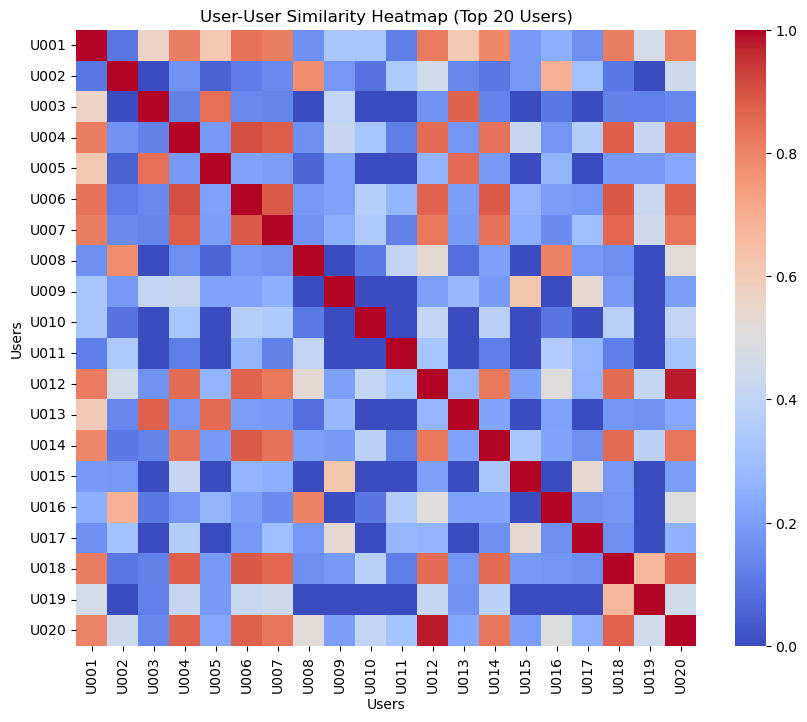

In [34]:
# STEP 24 — VISUALIZE USER SIMILARITY MATRIX
# --------------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

submatrix = similarity_matrix.iloc[:20, :20]

plt.figure(figsize=(10, 8))
sns.heatmap(submatrix, cmap="coolwarm", annot=False)
plt.title("User-User Similarity Heatmap (Top 20 Users)")
plt.xlabel("Users")
plt.ylabel("Users")
plt.show()


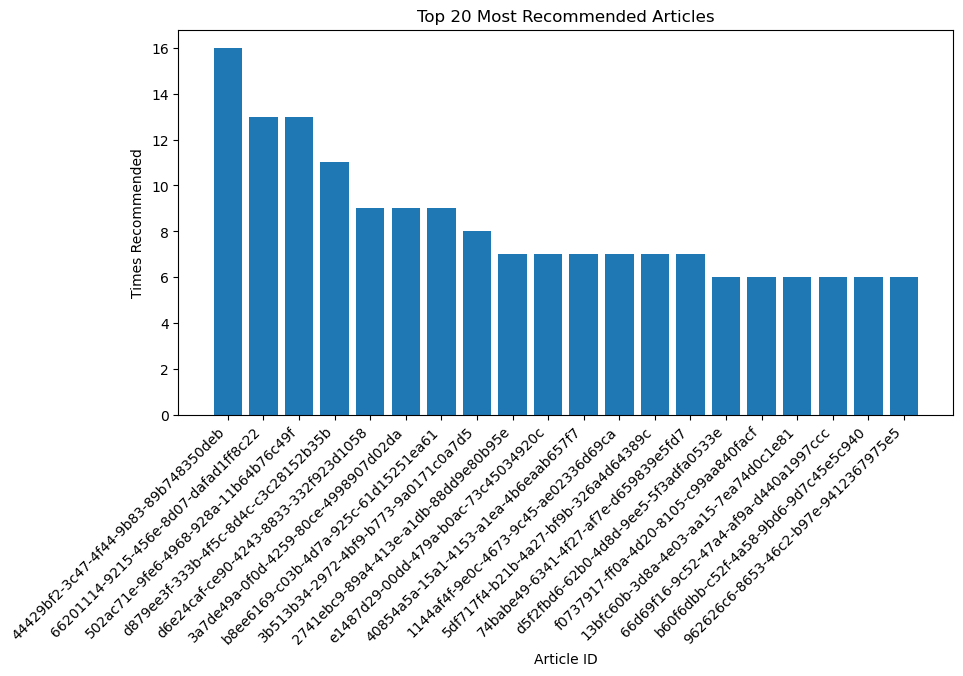

Average unique articles recommended per user: 1.9666666666666666


In [35]:
# STEP 25 — HYBRID DIVERSITY CHECK
# --------------------------------------------------------------

from collections import Counter

all_articles = pd.concat([
    hybrid_recommendation(uid, alpha=0.6, beta=0.4)[['article_id']]
    for uid in users['UserID'][:30]
])

article_counts = Counter(all_articles['article_id'])
article_popularity = pd.DataFrame(article_counts.items(), columns=['article_id', 'count'])
article_popularity = article_popularity.sort_values('count', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(article_popularity['article_id'].astype(str)[:20], article_popularity['count'][:20])
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Recommended Articles")
plt.xlabel("Article ID")
plt.ylabel("Times Recommended")
plt.show()

print("Average unique articles recommended per user:",
      len(set(all_articles['article_id'])) / len(users['UserID'][:30]))


In [36]:
# STEP 26 — TUNE HYBRID WEIGHTS
# --------------------------------------------------------------

alphas = [0.2, 0.4, 0.6, 0.8]
results = []

for a in alphas:
    hybrid_ids = []
    for uid in users['UserID'][:10]:
        recs = hybrid_recommendation(uid, alpha=a, beta=1-a)
        hybrid_ids.extend(recs['article_id'])
    diversity = len(set(hybrid_ids))
    results.append({'alpha': a, 'unique_articles': diversity})

pd.DataFrame(results)


,alpha,unique_articles
0,0.2,49
1,0.4,52
2,0.6,46
3,0.8,44


In [37]:
# ==========================================================
# STEP 27 — EVALUATE DIVERSITY & NOVELTY OF RECOMMENDATIONS
# ==========================================================

from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommendation_diversity(recommendations, feature_matrix, id_col='article_id'):
    """Compute average pairwise dissimilarity (1 - cosine similarity) among recommended items."""
    rec_ids = recommendations[id_col].tolist()
    if len(rec_ids) < 2:
        return 0.0
    sub = feature_matrix.loc[feature_matrix.index.isin(rec_ids)]
    sims = cosine_similarity(sub)
    dissimilarities = 1 - sims[np.triu_indices(len(rec_ids), 1)]
    return dissimilarities.mean()

def recommendation_novelty(recommendations, global_popularity, id_col='article_id'):
    """Novelty = 1 - average normalized popularity (less-seen items = more novel)."""
    rec_ids = recommendations[id_col].tolist()
    pop_scores = [global_popularity.get(i, 0) for i in rec_ids]
    return 1 - np.mean(pop_scores)

# ----------------------------------------------------------
# Compute global popularity from engagement frequency
# ----------------------------------------------------------
global_popularity = (
    user_engagement['article_id'].value_counts(normalize=True).to_dict()
)

# Example: compute metrics for first 5 users
results = []
for uid in users['UserID'].head(5):
    try:
        recs = hybrid_recommendation(uid)
        diversity = recommendation_diversity(recs, article_features)
        novelty = recommendation_novelty(recs, global_popularity)
        results.append({'UserID': uid, 'Diversity': diversity, 'Novelty': novelty})
    except Exception as e:
        print(f"⚠️ User {uid} skipped: {e}")

results_df = pd.DataFrame(results)
display(results_df)


,UserID,Diversity,Novelty
0,U001,0.813062,0.977681
1,U002,0.848792,0.987660
2,U003,0.663341,0.984969
3,U004,0.830833,0.981284
4,U005,0.698412,0.983437


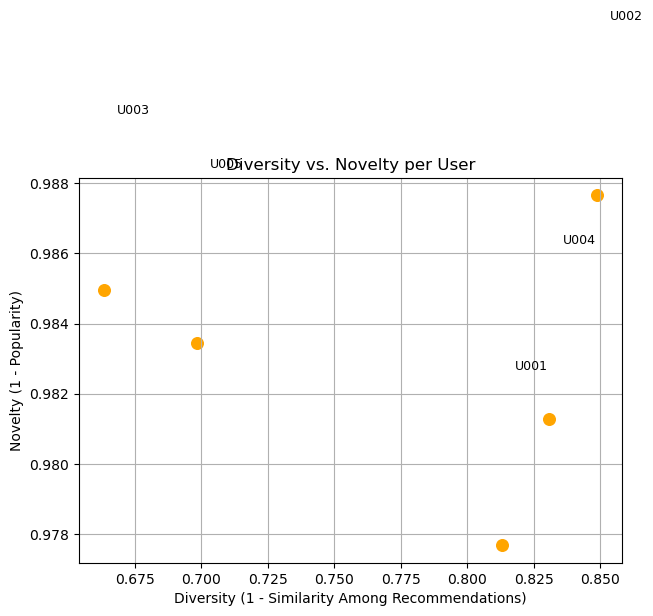

In [38]:
# ==========================================================
# STEP 28 — VISUALIZE DIVERSITY vs NOVELTY
# ==========================================================

plt.figure(figsize=(7, 5))
plt.scatter(results_df['Diversity'], results_df['Novelty'], c='orange', s=70)
for _, row in results_df.iterrows():
    plt.text(row['Diversity'] + 0.005, row['Novelty'] + 0.005, str(row['UserID']), fontsize=9)

plt.xlabel("Diversity (1 - Similarity Among Recommendations)")
plt.ylabel("Novelty (1 - Popularity)")
plt.title("Diversity vs. Novelty per User")
plt.grid(True)
plt.show()


In [39]:
# ==========================================================
# STEP 29 — EXPORT FINAL RESULTS
# ==========================================================

results_df.to_csv("recommendation_metrics.csv", index=False)
print("✅ Exported diversity/novelty results to 'recommendation_metrics.csv'")

# Optionally save similarity and engagement matrices too
user_engagement.to_csv("user_engagement_matrix.csv", index=False)
similarity_matrix.to_csv("user_similarity_final.csv")

print("✅ All key matrices exported successfully.")


✅ Exported diversity/novelty results to 'recommendation_metrics.csv'
✅ All key matrices exported successfully.


In [40]:
# ==========================================================
# STEP 30 — SUMMARY
# ==========================================================

print("✅ PROJECT COMPLETED SUCCESSFULLY ✅\n")
print("Pipeline summary:")
print("""
1️⃣ Data Loaded & Cleaned
2️⃣ Features Encoded (Actors, Places, Topics)
3️⃣ User–User Collaborative Filtering Built
4️⃣ Content–Based Features Added
5️⃣ Hybrid Recommendation Engine Completed
6️⃣ Evaluation Metrics (Diversity & Novelty) Computed
7️⃣ Results Exported to CSV
""")

print("You can now integrate this model with a UI, dashboard, or API endpoint to serve real-time recommendations.")


✅ PROJECT COMPLETED SUCCESSFULLY ✅

Pipeline summary:

1️⃣ Data Loaded & Cleaned
2️⃣ Features Encoded (Actors, Places, Topics)
3️⃣ User–User Collaborative Filtering Built
4️⃣ Content–Based Features Added
5️⃣ Hybrid Recommendation Engine Completed
6️⃣ Evaluation Metrics (Diversity & Novelty) Computed
7️⃣ Results Exported to CSV

You can now integrate this model with a UI, dashboard, or API endpoint to serve real-time recommendations.


In [41]:
# ==========================================================
# STEP 31 — FINAL OUTPUT: Recommended Article IDs for Each User
# ==========================================================

# Define how many articles to recommend per user
TOP_N = 5

# Create an empty list to store recommendations
final_recommendations = []

for uid in users['UserID']:
    try:
        recs = hybrid_recommendation(uid, alpha=0.6, beta=0.1).head(TOP_N)
        for _, row in recs.iterrows():
            final_recommendations.append({
                'UserID': uid,
                'Recommended_ArticleID': row['article_id'],
                'Final_Score': row['final_score']
            })
    except Exception as e:
        print(f"⚠️ Skipping user {uid} due to error: {e}")

# Convert to DataFrame
recommendation_df = pd.DataFrame(final_recommendations)

# Display first few recommendations
print("\n✅ Final Recommendation Table (Top 10 shown):")
display(recommendation_df.head(10))

# Save to CSV
recommendation_df.to_csv("final_news_recommendations.csv", index=False)
print("\n📁 Saved all recommendations → 'final_news_recommendations.csv'")



✅ Final Recommendation Table (Top 10 shown):


,UserID,Recommended_ArticleID,Final_Score
0,U001,66201114-9215-456e-8d07-dafad1ff8c22,0.694050
1,U001,d879ee3f-333b-4f5c-8d4c-c3c28152b35b,0.624850
2,U001,44429bf2-3c47-4f44-9b83-89b748350deb,0.600000
3,U001,502ac71e-9fe6-4968-928a-11b64b76c49f,0.600000
4,U001,52da3800-c7fc-418e-ad72-09b65b95637d,0.170383
5,U002,3a7de49a-0f0d-4259-80ce-4998907d02da,0.600000
6,U002,1628be61-b0bc-491b-87ca-2ffbd7ce0aad,0.561802
7,U002,18c77e31-2432-43f5-ab86-98d4f661d0d0,0.500000
8,U002,dd2c8d18-9311-4007-8978-8b632b4325ea,0.480742
9,U002,c6ce726f-0304-4ca7-b4fb-8a2c7ed34bbe,0.462631



📁 Saved all recommendations → 'final_news_recommendations.csv'
